步骤：

1. 数据清洗：查看异常值，训练数据集和测试数据集的配对情况，并针对是否配对生成只包含测试数据集数据的训练数据
2. 数据类型转换：将类别数据通过LabelEncode库将其转化为numeric的标签
3. 由于需要以月为单位对每个商铺的每个商品第34个月的销售量进行预测，因此需要以月为单位对原数据进行聚合
4. 在建立模型时主要考虑的有两方面，一个是不同的商铺和商品类别对销量的影响，一个是时间对销量的影响（这个时间需要考虑的因素也是多方面的，比如开店关店时的促销活动，商品销量的季节性以及节日性的变化还有过去的销量是否对未来的销量有影响），因此在构造特征时会主要考虑从这两个方面开展
5. 模型对比：主要用线性回归和随机森林两种模型进行训练，对比分数

模型优化思路：

1. 仅使用已有的类别数据，例如商品类别，商铺类别等特征（注意要将值域锁定在0-20之间并且删除异常值，否则对结果影响巨大）
2. 加入时间特征和时间序列特征
3. 使用不同模型训练并通过删改加入模型的features和模型参数来优化

1.（1）数据输入

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [185]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import datetime

In [186]:
categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
train1=pd.read_csv('sales_train.csv')
sample=pd.read_csv('sample_submission.csv')
shops=pd.read_csv('shops.csv')
test=pd.read_csv('test.csv')

1.（2）对比训练数据集和测试数据集的配对情况

这里生成了两个训练集，一个源训练集，一个是剔除了所有在测试集中未出现过的shop_id和item_id配对的训练集。这是优化模型的一个思路，通过查阅kaggle竞赛相关文章，发现有人建议将测试集中未出现的ID剔除出去会增加分数。因此本次训练会针对这两个训练数据集的结果进行对比。
https://blog.csdn.net/wlx19970505/article/details/101014813/

In [187]:
# deal with data leakage problems could improve score
# Use only the shop_id and item_id that appear on the test set

test_shop_ids=test['shop_id'].unique()
test_item_ids=test['item_id'].unique()

In [188]:
lk_train1=train1[train1['shop_id'].isin(test_shop_ids)]
lk_train2=lk_train1[lk_train1['item_id'].isin(test_item_ids)]

In [189]:
print("number of paired shop id in train set:", len(lk_train1))
print("length of train set:",len(train1))
print("number of paired item id in train set:", len(lk_train2))
print("length of train set:",len(train1))

#源数据集中不到50%的配对与测试集匹配

number of paired shop id in train set: 2413246
length of train set: 2935849
number of paired item id in train set: 1224439
length of train set: 2935849


1.（3）处理异常值

异常值对模型准确性影响非常大，因此对于两个训练集中的价格和销量均剔除负数和过于大的值

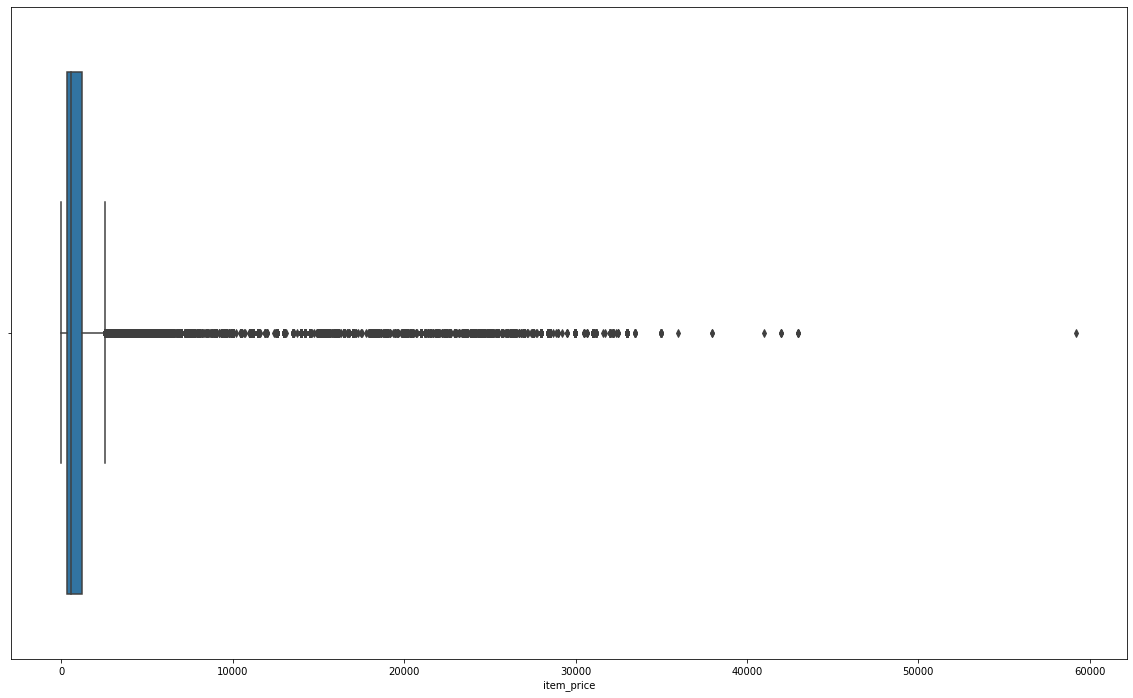

In [190]:
plt.figure(figsize=(20,12))
sns.boxplot(data=lk_train2, x='item_price')

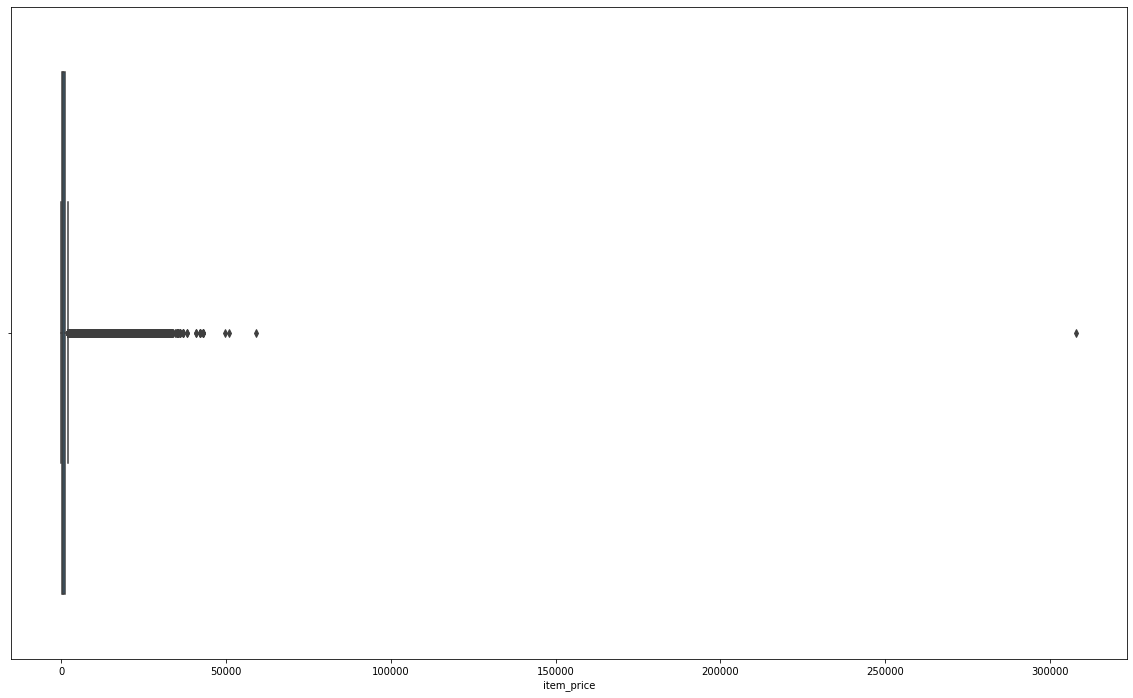

In [191]:
plt.figure(figsize=(20,12))
sns.boxplot(data=train1, x='item_price')

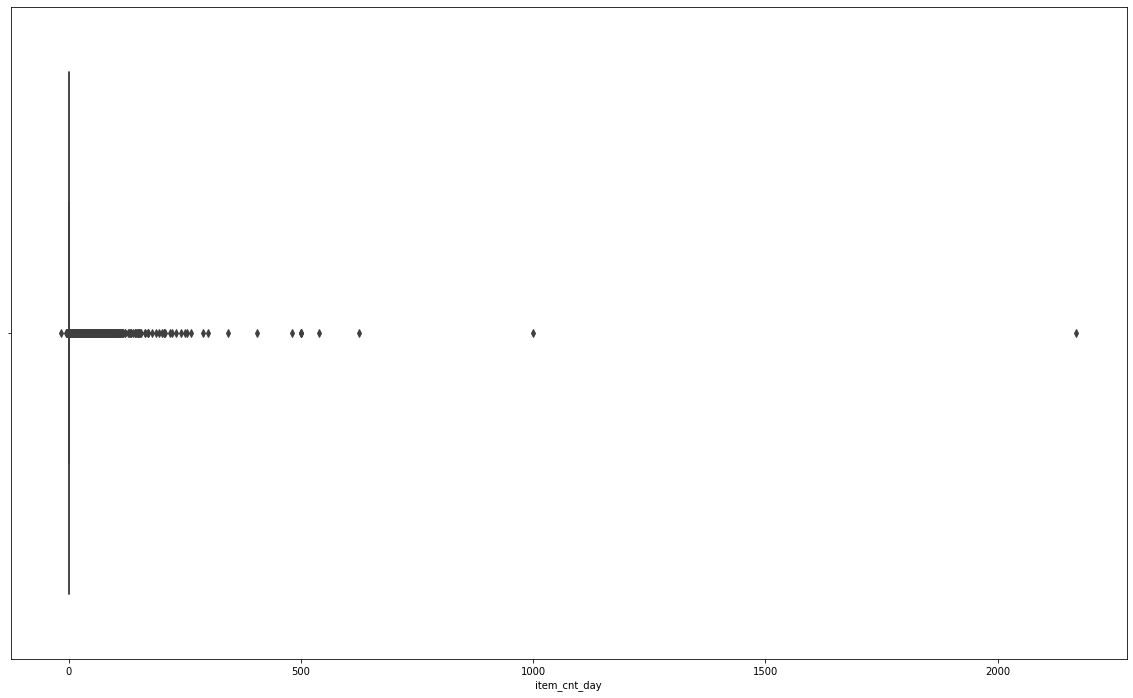

In [192]:
plt.figure(figsize=(20,12))
sns.boxplot(data=lk_train2, x='item_cnt_day')

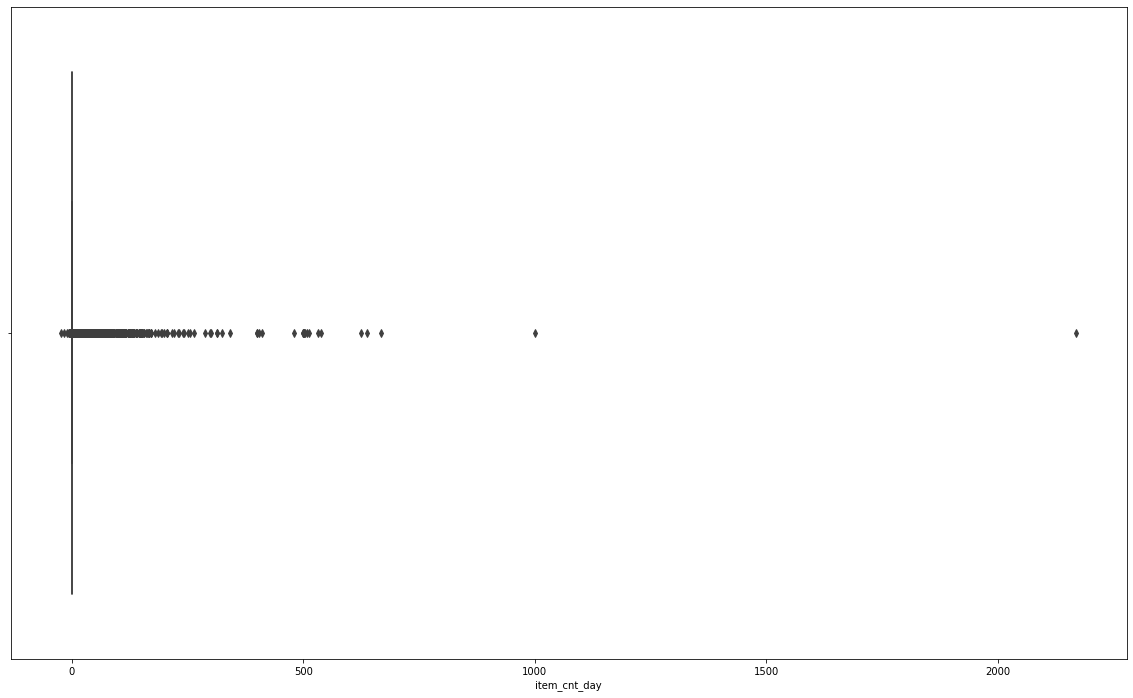

In [193]:
plt.figure(figsize=(20,12))
sns.boxplot(data=train1, x='item_cnt_day')

In [194]:
lk_train=lk_train2[lk_train2['item_price']<50000]
lk_train=lk_train[lk_train['item_price']>0]
lk_train=lk_train[lk_train['item_cnt_day']<1000]
lk_train=lk_train[lk_train['item_cnt_day']>0]

In [195]:
train=train1[train1['item_price']<50000]
train=train[train['item_price']>0]
train=train[train['item_cnt_day']<1000]
train=train[train['item_cnt_day']>0]

2.(1) 特征工程

分别针对训练集和各个补充数据集进行特征处理，分别将商铺信息和商品类别信息转化为数字标签，并以月为单位根据不同商铺不同商品对销售量进行聚合

In [196]:
# 计算总销售额
train['revenue']=train['item_price']*train['item_cnt_day']
lk_train['revenue']=lk_train['item_price']*lk_train['item_cnt_day']

In [197]:
# 处理商铺信息，由于是俄语，此处参考 https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data

shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


In [198]:
# 处理类别数据

shop_city_la=preprocessing.LabelEncoder()
shop_city_la.fit(shops['shop_city'])
city_labels=shop_city_la.transform(shops['shop_city'])
shops['shop_city_labeled']=city_labels

shop_type_la=preprocessing.LabelEncoder()
shop_type_la.fit(shops['shop_type'])
type_labels=shop_type_la.transform(shops['shop_type'])
shops['shop_type_labeled']=type_labels

shops

,shop_name,shop_id,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,якутск орджоникидзе фран,0,якутск,NO_DATA,29,0
1,якутск тц центральный фран,1,якутск,тц,29,5
2,адыгея тц мега,2,адыгея,тц,0,5
3,балашиха трк октябрькиномир,3,балашиха,трк,1,3
4,волжский тц волга молл,4,волжский,тц,2,5
5,вологда трц мармелад,5,вологда,трц,3,4
6,воронеж плехановская,6,воронеж,NO_DATA,4,0
7,воронеж трц максимир,7,воронеж,трц,4,4
8,воронеж трц ситипарк град,8,воронеж,трц,4,4
9,выездная торговля,9,выездная,NO_DATA,5,0


In [199]:
# 同理，处理类别数据

cat_type_la=preprocessing.LabelEncoder()
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
cat_type_la.fit(categories['type'])
cat_type_labels=cat_type_la.transform(categories['type'])
categories['type_code'] = cat_type_labels

cat_subtype_la=preprocessing.LabelEncoder()
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cat_subtype_la.fit(categories['subtype'])
cat_subtype_labels=cat_subtype_la.transform(categories['subtype'])
categories['subtype_code'] = cat_subtype_labels

In [200]:
categories

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13
...,...,...,...,...,...,...,...
79,Служебные,79,[Служебные],Служебные,16,Служебные,54
80,Служебные - Билеты,80,"[Служебные , Билеты]",Служебные,16,Билеты,25
81,Чистые носители (шпиль),81,[Чистые носители (шпиль)],Чистые носители (шпиль),17,Чистые носители (шпиль),62
82,Чистые носители (штучные),82,[Чистые носители (штучные)],Чистые носители (штучные),18,Чистые носители (штучные),63


In [201]:
# 同参考 https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data，删除重复的商铺

# Якутск Орджоникидзе, 56
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
lk_train.loc[lk_train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
lk_train.loc[lk_train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [202]:
# 以月为单位聚合

train_groupby_month=train.sort_values('date').groupby(['date_block_num','shop_id','item_id'],as_index=False)
train_groupby_agg=train_groupby_month.agg({'item_cnt_day':['sum'],'item_price':['sum']})
train_groupby_agg.columns=['date_block_num','shop_id','item_id','item_sum_cnt','revenue']

lk_train_groupby_month=lk_train.sort_values('date').groupby(['date_block_num','shop_id','item_id'],as_index=False)
lk_train_groupby_agg=lk_train_groupby_month.agg({'item_cnt_day':['sum'],'item_price':['sum']})
lk_train_groupby_agg.columns=['date_block_num','shop_id','item_id','item_sum_cnt','revenue']

In [203]:
train_groupby_agg

,date_block_num,shop_id,item_id,item_sum_cnt,revenue
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,798.0
...,...,...,...,...,...
1608218,33,59,22087,6.0,357.0
1608219,33,59,22088,2.0,238.0
1608220,33,59,22091,1.0,179.0
1608221,33,59,22100,1.0,629.0


In [204]:
lk_train_groupby_agg

,date_block_num,shop_id,item_id,item_sum_cnt,revenue
0,0,2,33,1.0,499.0
1,0,2,482,1.0,3300.0
2,0,2,491,1.0,600.0
3,0,2,839,1.0,3300.0
4,0,2,1007,3.0,1347.0
...,...,...,...,...,...
599906,33,59,22087,6.0,357.0
599907,33,59,22088,2.0,238.0
599908,33,59,22091,1.0,179.0
599909,33,59,22100,1.0,629.0


3. 处理测试集

将测试集与训练集合并以更好地训练模型

In [205]:
# 测试集为第34个月的商铺商品的信息

test['date_block_num']=34

In [206]:
train_test=pd.concat([test,train_groupby_agg],ignore_index=True,sort=False)
lk_train_test=pd.concat([test,lk_train_groupby_agg],ignore_index=True,sort=False)

In [207]:
train_test

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue
0,0.0,5,5037,34,NaN,NaN
1,1.0,5,5320,34,NaN,NaN
2,2.0,5,5233,34,NaN,NaN
3,3.0,5,5232,34,NaN,NaN
4,4.0,5,5268,34,NaN,NaN
...,...,...,...,...,...,...
1822418,NaN,59,22087,33,6.0,357.0
1822419,NaN,59,22088,33,2.0,238.0
1822420,NaN,59,22091,33,1.0,179.0
1822421,NaN,59,22100,33,1.0,629.0


In [208]:
lk_train_test

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue
0,0.0,5,5037,34,NaN,NaN
1,1.0,5,5320,34,NaN,NaN
2,2.0,5,5233,34,NaN,NaN
3,3.0,5,5232,34,NaN,NaN
4,4.0,5,5268,34,NaN,NaN
...,...,...,...,...,...,...
814106,NaN,59,22087,33,6.0,357.0
814107,NaN,59,22088,33,2.0,238.0
814108,NaN,59,22091,33,1.0,179.0
814109,NaN,59,22100,33,1.0,629.0


In [209]:
# 补充缺失值

train_test['ID']=train_test['ID'].fillna(1000000)
train_test['item_sum_cnt']=train_test['item_sum_cnt'].fillna(0)
train_test['revenue']=train_test['revenue'].fillna(0)

lk_train_test['ID']=lk_train_test['ID'].fillna(1000000)
lk_train_test['item_sum_cnt']=lk_train_test['item_sum_cnt'].fillna(0)
lk_train_test['revenue']=lk_train_test['revenue'].fillna(0)

In [210]:
# 将所有数据集整合在一起

In [211]:
All_train_join=train_test.join(items,on='item_id',rsuffix='_').join(categories,on='item_category_id',rsuffix='_').join(shops,on='shop_id',rsuffix='_').drop(['item_id_','shop_id_','item_category_id_'],axis=1)
All_train_join.columns
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,13,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,5,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",Игры,5,PS4,11,вологда трц мармелад,вологда,трц,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",Книги,12,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5


In [212]:
All_lk_train_join=lk_train_test.join(items,on='item_id',rsuffix='_').join(categories,on='item_category_id',rsuffix='_').join(shops,on='shop_id',rsuffix='_').drop(['item_id_','shop_id_','item_category_id_'],axis=1)
All_lk_train_join.columns
All_lk_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,13,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,5,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",Игры,5,PS4,11,вологда трц мармелад,вологда,трц,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814106,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814107,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814108,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814109,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",Книги,12,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5


优化点：将所有的销售额范围clip在0-20之间，因为目标范围为0-20，这样就和测试集的数值范围相符

In [213]:
All_train_join['item_sum_cnt']=All_train_join['item_sum_cnt'].clip(0,20)
All_lk_train_join['item_sum_cnt']=All_lk_train_join['item_sum_cnt'].clip(0,20)

In [214]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,13,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,5,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",Игры,5,PS4,11,вологда трц мармелад,вологда,трц,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",Книги,12,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5


In [215]:
All_lk_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,13,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,5,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",Игры,5,PS4,11,вологда трц мармелад,вологда,трц,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814106,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814107,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814108,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
814109,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",Книги,12,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5


4. 增添lagged feature和年月特征

第三部分主要在时间序列维度挖掘数据，增加滞后特征以便将时间，季度等影响因素加入到模型中

In [216]:
# 增加年月特征

def convert(date_block):
    date = datetime.datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return date

All_train_join['year_month']=All_train_join['date_block_num'].apply(lambda x:convert(x))
All_train_join['Year']=All_train_join['year_month'].apply(lambda x:x.year)
All_train_join['Month']=All_train_join['year_month'].apply(lambda x:x.month)

All_lk_train_join['year_month']=All_lk_train_join['date_block_num'].apply(lambda x:convert(x))
All_lk_train_join['Year']=All_lk_train_join['year_month'].apply(lambda x:x.year)
All_lk_train_join['Month']=All_lk_train_join['year_month'].apply(lambda x:x.month)

In [217]:
# 增加lagged features以及mean encoded features

lag_list=[1,2,3]

for lag in lag_list:
    ft_name=('item_cnt_shop_item_lagged%s' % lag)
    All_train_join[ft_name]=All_train_join.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_train_join[ft_name].fillna(0, inplace=True)

for lag in lag_list:
    ft_name=('item_cnt_shop_item_lagged%s' % lag)
    All_lk_train_join[ft_name]=All_lk_train_join.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_lk_train_join[ft_name].fillna(0, inplace=True)

In [218]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,shop_city,shop_type,shop_city_labeled,shop_type_labeled,year_month,Year,Month,item_cnt_shop_item_lagged1,item_cnt_shop_item_lagged2,item_cnt_shop_item_lagged3
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,3.0,1.0
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,вологда,трц,3,4,2015-11-01,2015,11,0.0,0.0,0.0
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,3.0,1.0
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,0.0,0.0
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,вологда,трц,3,4,2015-11-01,2015,11,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,3.0,2.0,5.0
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,1.0,7.0,7.0
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,3.0,1.0,1.0
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,ярославль,тц,30,5,2015-10-01,2015,10,1.0,0.0,0.0


In [219]:
All_lk_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,shop_city,shop_type,shop_city_labeled,shop_type_labeled,year_month,Year,Month,item_cnt_shop_item_lagged1,item_cnt_shop_item_lagged2,item_cnt_shop_item_lagged3
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,3.0,1.0
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,вологда,трц,3,4,2015-11-01,2015,11,0.0,0.0,0.0
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,3.0,1.0
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,вологда,трц,3,4,2015-11-01,2015,11,1.0,0.0,0.0
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,вологда,трц,3,4,2015-11-01,2015,11,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814106,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,3.0,2.0,5.0
814107,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,1.0,7.0,7.0
814108,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2015-10-01,2015,10,3.0,1.0,1.0
814109,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,ярославль,тц,30,5,2015-10-01,2015,10,1.0,0.0,0.0


优化点：加入mean encoded features

加入平均值的理由：通过构造按照不同条件计算的均值，可以进一步计算销售量和价格的变化趋势。

In [220]:
group = All_train_join.groupby(['shop_id', 'item_id']).agg({'item_sum_cnt':['mean']})
group.columns =['shop_item_avg_cnt']
group.reset_index(inplace=True)
All_train_join=pd.merge(All_train_join,group,on=['shop_id', 'item_id'],how='left')

In [221]:
group = All_lk_train_join.groupby(['shop_id', 'item_id']).agg({'item_sum_cnt':['mean']})
group.columns =['shop_item_avg_cnt']
group.reset_index(inplace=True)
All_lk_train_join=pd.merge(All_lk_train_join,group,on=['shop_id', 'item_id'],how='left')

优化点：在代码上，本是使用def嵌套来批量完成lagged features的建立，但是由于这种写法运行起来占用GPU过高，因此使用了较繁琐的写法来完成这一步骤

In [222]:
#def lag_feature(df, lags, col):
    #tmp = df[['date_block_num','shop_id','item_id',col]]
    #for i in lags:
        #shifted = tmp.copy()
        #shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        #shifted['date_block_num'] += i
        #df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    #return df

In [223]:
# groupby shop_id, item_category_id, and item_id

lag_list=[1,2,3]

for lag in lag_list:
    ft_name=('item_cnt_cat_lagged%s' % lag)
    All_train_join[ft_name]=All_train_join.sort_values('date_block_num').groupby(['shop_id','item_category_id','item_id'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_train_join[ft_name].fillna(0, inplace=True)

for lag in lag_list:
    ft_name=('item_cnt_cat_lagged%s' % lag)
    All_lk_train_join[ft_name]=All_lk_train_join.sort_values('date_block_num').groupby(['shop_id','item_category_id','item_id'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_lk_train_join[ft_name].fillna(0, inplace=True)
    
group1 = All_train_join.groupby(['shop_id','item_category_id','item_id']).agg({'item_sum_cnt':['mean']})
group1.columns =['shop_item_cat_avg_cnt']
group1.reset_index(inplace=True)
All_train_join=pd.merge(All_train_join,group1,on=['shop_id', 'item_category_id','item_id'],how='left')
All_train_join['shop_item_cat_avg_cnt']=All_train_join['shop_item_cat_avg_cnt'].astype(np.float16)

group2 = All_lk_train_join.groupby(['shop_id','item_category_id','item_id']).agg({'item_sum_cnt':['mean']})
group2.columns =['shop_item_cat_avg_cnt']
group2.reset_index(inplace=True)
All_lk_train_join=pd.merge(All_lk_train_join,group2,on=['shop_id', 'item_category_id','item_id'],how='left')
All_lk_train_join['shop_item_cat_avg_cnt']=All_lk_train_join['shop_item_cat_avg_cnt'].astype(np.float16)

In [224]:
# groupby date, shop, and category

lag_list=[1,2,3]

for lag in lag_list:
    ft_name=('item_cnt_date_shop_cat_lagged%s' % lag)
    All_train_join[ft_name]=All_train_join.sort_values('date_block_num').groupby(['shop_id','item_category_id','date_block_num'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_train_join[ft_name].fillna(0, inplace=True)

for lag in lag_list:
    ft_name=('item_cnt_date_shop_cat_lagged%s' % lag)
    All_lk_train_join[ft_name]=All_lk_train_join.sort_values('date_block_num').groupby(['shop_id','item_category_id','date_block_num'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_lk_train_join[ft_name].fillna(0, inplace=True)
    
group1 = All_train_join.groupby(['shop_id','item_category_id','date_block_num']).agg({'item_sum_cnt':['mean']})
group1.columns =['shop_date_cat_avg_cnt']
group1.reset_index(inplace=True)
All_train_join=pd.merge(All_train_join,group1,on=['shop_id','item_category_id','date_block_num'],how='left')
All_train_join['shop_date_cat_avg_cnt']=All_train_join['shop_date_cat_avg_cnt'].astype(np.float16)

group2 = All_lk_train_join.groupby(['shop_id','item_category_id','date_block_num']).agg({'item_sum_cnt':['mean']})
group2.columns =['shop_date_cat_avg_cnt']
group2.reset_index(inplace=True)
All_lk_train_join=pd.merge(All_lk_train_join,group2,on=['shop_id','item_category_id','date_block_num'],how='left')
All_lk_train_join['shop_date_cat_avg_cnt']=All_lk_train_join['shop_date_cat_avg_cnt'].astype(np.float16)

In [225]:
# groupby date, shop and item

lag_list=[1,2,3]

for lag in lag_list:
    ft_name=('item_cnt_date_shop_item_lagged%s' % lag)
    All_train_join[ft_name]=All_train_join.sort_values('date_block_num').groupby(['shop_id','item_id','date_block_num'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_train_join[ft_name].fillna(0, inplace=True)

for lag in lag_list:
    ft_name=('item_cnt_date_shop_item_lagged%s' % lag)
    All_lk_train_join[ft_name]=All_lk_train_join.sort_values('date_block_num').groupby(['shop_id','item_id','date_block_num'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_lk_train_join[ft_name].fillna(0, inplace=True)
    
group1 = All_train_join.groupby(['shop_id','item_id','date_block_num']).agg({'item_sum_cnt':['mean']})
group1.columns =['shop_date_item_avg_cnt']
group1.reset_index(inplace=True)
All_train_join=pd.merge(All_train_join,group1,on=['shop_id','item_id','date_block_num'],how='left')
All_train_join['shop_date_item_avg_cnt']=All_train_join['shop_date_item_avg_cnt'].astype(np.float16)

group2 = All_lk_train_join.groupby(['shop_id','item_id','date_block_num']).agg({'item_sum_cnt':['mean']})
group2.columns =['shop_date_item_avg_cnt']
group2.reset_index(inplace=True)
All_lk_train_join=pd.merge(All_lk_train_join,group2,on=['shop_id','item_id','date_block_num'],how='left')
All_lk_train_join['shop_date_item_avg_cnt']=All_lk_train_join['shop_date_item_avg_cnt'].astype(np.float16)

In [226]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,item_cnt_cat_lagged3,shop_item_cat_avg_cnt,item_cnt_date_shop_cat_lagged1,item_cnt_date_shop_cat_lagged2,item_cnt_date_shop_cat_lagged3,shop_date_cat_avg_cnt,item_cnt_date_shop_item_lagged1,item_cnt_date_shop_item_lagged2,item_cnt_date_shop_item_lagged3,shop_date_item_avg_cnt
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,1.0,1.299805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,1.0,1.666992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,5.0,6.234375,2.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,7.0,5.968750,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,1.0,2.166016,6.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,0.0,0.666504,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [227]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [228]:
group1 = train.groupby(['item_id']).agg({'item_price': ['mean']})
group1.columns = ['item_avg_item_price']
group1.reset_index(inplace=True)

All_train_join = pd.merge(All_train_join, group1, on=['item_id'], how='left')
All_train_join['item_avg_item_price']=All_train_join['item_avg_item_price'].astype(np.float16)

group2 = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group2.columns = ['date_item_avg_item_price']
group2.reset_index(inplace=True)

All_train_join = pd.merge(All_train_join, group2, on=['date_block_num','item_id'], how='left')
All_train_join['date_item_avg_item_price']=All_train_join['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3]
All_train_join = lag_feature(All_train_join, lags, 'date_item_avg_item_price')

In [229]:
group1 = lk_train.groupby(['item_id']).agg({'item_price': ['mean']})
group1.columns = ['item_avg_item_price']
group1.reset_index(inplace=True)

All_lk_train_join = pd.merge(All_lk_train_join, group1, on=['item_id'], how='left')
All_lk_train_join['item_avg_item_price']=All_lk_train_join['item_avg_item_price'].astype(np.float16)

group2 = lk_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group2.columns = ['date_item_avg_item_price']
group2.reset_index(inplace=True)

All_lk_train_join = pd.merge(All_lk_train_join, group2, on=['date_block_num','item_id'], how='left')
All_lk_train_join['date_item_avg_item_price']=All_lk_train_join['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3]
All_lk_train_join = lag_feature(All_lk_train_join, lags, 'date_item_avg_item_price')

In [230]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,shop_date_cat_avg_cnt,item_cnt_date_shop_item_lagged1,item_cnt_date_shop_item_lagged2,item_cnt_date_shop_item_lagged3,shop_date_item_avg_cnt,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,0.0,0.0,0.0,0.0,0.0,1924.000,NaN,NaN,936.500,894.5000
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,0.0,0.0,0.0,0.0,0.0,801.000,NaN,1199.000,711.500,712.0000
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,0.0,0.0,0.0,0.0,0.0,787.500,NaN,NaN,NaN,642.5000
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,3.0,0.0,0.0,0.0,6.0,88.000,119.0000,116.125,117.875,115.6250
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,3.0,0.0,0.0,0.0,2.0,91.750,118.5625,118.125,117.500,117.9375
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,3.0,0.0,0.0,0.0,1.0,128.125,176.3750,178.000,NaN,NaN
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,1.0,0.0,0.0,0.0,1.0,627.500,629.0000,625.000,NaN,NaN


优化点：计算price的变化趋势，添加趋势feature，价格趋势的计算公式是（不同滞后时期的价格-每个商品的平均价格）/商品平均价格，也就是商品在不同时期针对平均价格的变化趋势

In [231]:
lags = [1,2,3]

for i in lags:
    All_train_join['delta_price_lag_'+str(i)] = \
        (All_train_join['date_item_avg_item_price_lag_'+str(i)] - All_train_join['item_avg_item_price']) / All_train_join['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
All_train_join['delta_price_lag'] = All_train_join.apply(select_trend, axis=1)
All_train_join['delta_price_lag'] = All_train_join['delta_price_lag'].astype(np.float16)
All_train_join['delta_price_lag'].fillna(0, inplace=True)



In [232]:
lags = [1,2,3]

for i in lags:
    All_lk_train_join['delta_price_lag_'+str(i)] = \
        (All_lk_train_join['date_item_avg_item_price_lag_'+str(i)] - All_lk_train_join['item_avg_item_price']) / All_lk_train_join['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
All_lk_train_join['delta_price_lag'] = All_lk_train_join.apply(select_trend, axis=1)
All_lk_train_join['delta_price_lag'] = All_lk_train_join['delta_price_lag'].astype(np.float16)
All_lk_train_join['delta_price_lag'].fillna(0, inplace=True)

In [233]:
# 计算销售额相关lagged feature

group1 = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group1.columns = ['date_shop_revenue']
group1.reset_index(inplace=True)

All_train_join = pd.merge(All_train_join, group1, on=['date_block_num','shop_id'], how='left')
All_train_join['date_shop_revenue'] = All_train_join['date_shop_revenue'].astype(np.float32)

group2 = group1.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group2.columns = ['shop_avg_revenue']
group2.reset_index(inplace=True)

All_train_join = pd.merge(All_train_join, group2, on=['shop_id'], how='left')
All_train_join['shop_avg_revenue'] = All_train_join['shop_avg_revenue'].astype(np.float32)

All_train_join['delta_revenue'] = (All_train_join['date_shop_revenue'] - All_train_join['shop_avg_revenue']) / All_train_join['shop_avg_revenue']
All_train_join['delta_revenue'] = All_train_join['delta_revenue'].astype(np.float16)

All_train_join = lag_feature(All_train_join, [1], 'delta_revenue')

#All_join.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [234]:
# 计算销售额相关lagged feature

group1 = lk_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group1.columns = ['date_shop_revenue']
group1.reset_index(inplace=True)

All_lk_train_join = pd.merge(All_lk_train_join, group1, on=['date_block_num','shop_id'], how='left')
All_lk_train_join['date_shop_revenue'] = All_lk_train_join['date_shop_revenue'].astype(np.float32)

group2 = group1.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group2.columns = ['shop_avg_revenue']
group2.reset_index(inplace=True)

All_lk_train_join = pd.merge(All_lk_train_join, group2, on=['shop_id'], how='left')
All_lk_train_join['shop_avg_revenue'] = All_lk_train_join['shop_avg_revenue'].astype(np.float32)

All_lk_train_join['delta_revenue'] = (All_lk_train_join['date_shop_revenue'] - All_lk_train_join['shop_avg_revenue']) / All_lk_train_join['shop_avg_revenue']
All_lk_train_join['delta_revenue'] = All_lk_train_join['delta_revenue'].astype(np.float16)

All_lk_train_join = lag_feature(All_lk_train_join, [1], 'delta_revenue')

#All_join.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [235]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag,date_shop_revenue,shop_avg_revenue,delta_revenue,delta_revenue_lag_1
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,936.500,894.5000,NaN,-0.513184,-0.535156,0.000000,NaN,1160400.375,NaN,NaN
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1160400.375,NaN,NaN
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,711.500,712.0000,0.496826,-0.111755,-0.111084,0.496826,NaN,1160400.375,NaN,-0.047729
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,NaN,642.5000,NaN,NaN,-0.184082,0.000000,NaN,1160400.375,NaN,NaN
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1160400.375,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,117.875,115.6250,0.319580,0.339600,0.313965,0.319580,974885.0,1335571.500,-0.27002,-0.175781
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,117.500,117.9375,0.287354,0.280762,0.285400,0.287354,974885.0,1335571.500,-0.27002,-0.175781
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,NaN,NaN,0.389160,NaN,NaN,0.389160,974885.0,1335571.500,-0.27002,-0.175781
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,NaN,NaN,-0.003983,NaN,NaN,-0.003983,974885.0,1335571.500,-0.27002,-0.175781


In [236]:
All_train_join['item_shop_first_sale'] = All_train_join['date_block_num'] - All_train_join.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
All_train_join['item_first_sale'] = All_train_join['date_block_num'] - All_train_join.groupby('item_id')['date_block_num'].transform('min')

All_lk_train_join['item_shop_first_sale'] = All_lk_train_join['date_block_num'] - All_lk_train_join.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
All_lk_train_join['item_first_sale'] = All_lk_train_join['date_block_num'] - All_lk_train_join.groupby('item_id')['date_block_num'].transform('min')

In [237]:
All_train_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag,date_shop_revenue,shop_avg_revenue,delta_revenue,delta_revenue_lag_1,item_shop_first_sale,item_first_sale
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,NaN,-0.513184,-0.535156,0.000000,NaN,1160400.375,NaN,NaN,14,14
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,NaN,NaN,NaN,0.000000,NaN,1160400.375,NaN,NaN,0,0
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,0.496826,-0.111755,-0.111084,0.496826,NaN,1160400.375,NaN,-0.047729,6,7
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,NaN,NaN,-0.184082,0.000000,NaN,1160400.375,NaN,NaN,3,3
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,NaN,NaN,NaN,0.000000,NaN,1160400.375,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822418,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,0.319580,0.339600,0.313965,0.319580,974885.0,1335571.500,-0.27002,-0.175781,33,33
1822419,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,0.287354,0.280762,0.285400,0.287354,974885.0,1335571.500,-0.27002,-0.175781,33,33
1822420,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,0.389160,NaN,NaN,0.389160,974885.0,1335571.500,-0.27002,-0.175781,31,33
1822421,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,-0.003983,NaN,NaN,-0.003983,974885.0,1335571.500,-0.27002,-0.175781,1,3


In [248]:
# 填充缺失值：由于测试集中很多商品商铺在源训练集中没有对应，所以会在价格和销售额相关的feature中会出现很多缺失值，在此全部填充为0

All_train_join=All_train_join.fillna(0)
All_lk_train_join=All_lk_train_join.fillna(0)

5. 模型训练

(1) All_train_join VS. All_lk_train_join
(2) Random Forest VS. Linear Regression

In [313]:
train_set=All_train_join[All_train_join['date_block_num'].isin(range(3,32))]
# as we use three lags, so the previous three months is no longer helpful.
validation_set=All_train_join[All_train_join['date_block_num'].isin(range(33,34))]
test_set=All_train_join[All_train_join['date_block_num'].isin(range(34,35))]

In [314]:
lk_train_set=All_lk_train_join[All_lk_train_join['date_block_num'].isin(range(3,32))]
# as we use three lags, so the previous three months is no longer helpful.
lk_validation_set=All_lk_train_join[All_lk_train_join['date_block_num'].isin(range(33,34))]
lk_test_set=All_lk_train_join[All_lk_train_join['date_block_num'].isin(range(34,35))]

In [315]:
train_set.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'item_sum_cnt', 'revenue',
       'item_name', 'item_category_id', 'item_category_name', 'split', 'type',
       'type_code', 'subtype', 'subtype_code', 'shop_name', 'shop_city',
       'shop_type', 'shop_city_labeled', 'shop_type_labeled', 'year_month',
       'Year', 'Month', 'item_cnt_shop_item_lagged1',
       'item_cnt_shop_item_lagged2', 'item_cnt_shop_item_lagged3',
       'shop_item_avg_cnt', 'item_cnt_cat_lagged1', 'item_cnt_cat_lagged2',
       'item_cnt_cat_lagged3', 'shop_item_cat_avg_cnt',
       'item_cnt_date_shop_cat_lagged1', 'item_cnt_date_shop_cat_lagged2',
       'item_cnt_date_shop_cat_lagged3', 'shop_date_cat_avg_cnt',
       'item_cnt_date_shop_item_lagged1', 'item_cnt_date_shop_item_lagged2',
       'item_cnt_date_shop_item_lagged3', 'shop_date_item_avg_cnt',
       'item_avg_item_price', 'date_item_avg_item_price',
       'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_av

Random Forest

In [316]:
rf_features=['shop_id', 'item_id',
       'type_code', 'subtype_code','shop_city_labeled', 'shop_type_labeled', 'Year', 'Month', 'item_cnt_shop_item_lagged1',
       'item_cnt_shop_item_lagged2', 'item_cnt_shop_item_lagged3',
       'shop_item_avg_cnt', 'item_cnt_cat_lagged1', 'item_cnt_cat_lagged2',
       'item_cnt_cat_lagged3', 'shop_item_cat_avg_cnt',
       'item_cnt_date_shop_cat_lagged1', 'item_cnt_date_shop_cat_lagged2',
       'item_cnt_date_shop_cat_lagged3','item_cnt_date_shop_item_lagged1', 'item_cnt_date_shop_item_lagged2',
       'item_cnt_date_shop_item_lagged3','date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_avg_item_price_lag_3', 'delta_price_lag_1',
       'delta_price_lag_2', 'delta_price_lag_3', 'delta_revenue_lag_1', 'item_shop_first_sale', 'item_first_sale']

In [317]:
rf_train=train_set[rf_features]
rf_val=validation_set[rf_features]
rf_test=test_set[rf_features]

In [318]:
rf_lk_train=lk_train_set[rf_features]
rf_lk_val=lk_validation_set[rf_features]
rf_lk_test=lk_test_set[rf_features]

In [319]:
Y_train=train_set['item_sum_cnt']
Y_validation=validation_set['item_sum_cnt']

In [320]:
Y_lk_train=lk_train_set['item_sum_cnt']
Y_lk_validation=lk_validation_set['item_sum_cnt']

In [321]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [322]:
rf_lk_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0, n_jobs=-1)
rf_lk_model.fit(rf_lk_train, Y_lk_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [ ]:
# 调参：需要花费太长时间，不适用于此

#best_score=0
#for max_depth in range(1,15):
    #model= RandomForestRegressor(n_estimators=50, max_depth=max_depth, random_state=0, n_jobs=-1)
    #model.fit(rf_train,Y_train)
    #score=model.score(rf_val,Y_validation)
    #if score>best_score:
        #best_score=score
        #best_parameters={'max_depth':max_depth}
        
#print("Best score:{:.2f}".format(best_score))
#print("Best parameters:{}".format(best_parameters))



In [324]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [342]:
score=rf_model.score(rf_val,Y_validation)
score

0.755406876088621

In [325]:
rf_lk_train_pred = rf_lk_model.predict(rf_lk_train)
rf_lk_val_pred = rf_lk_model.predict(rf_lk_val)
rf_lk_test_pred = rf_lk_model.predict(rf_lk_test)

In [326]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 1.4502053484316615
Validation rmse: 1.2554437488556074


In [327]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(Y_lk_train, rf_lk_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_lk_validation, rf_lk_val_pred)))

Train rmse: 1.4999658697112868
Validation rmse: 1.3794041819798835


In [328]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

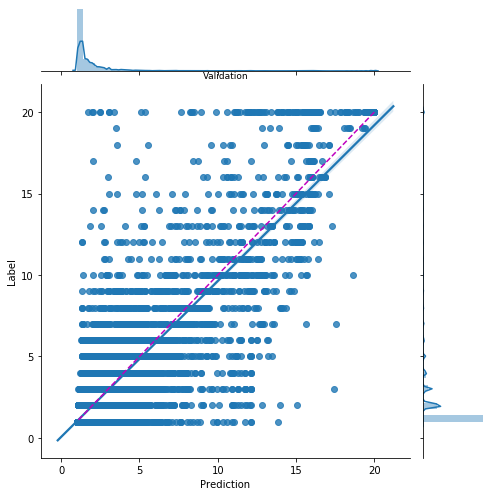

In [329]:
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

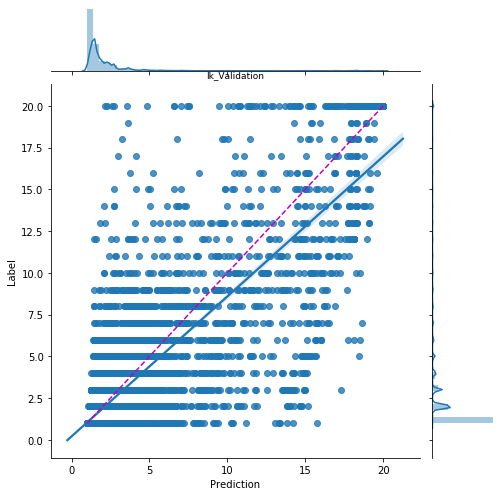

In [330]:
model_performance_sc_plot(rf_lk_val_pred, Y_lk_validation, 'lk_Validation')

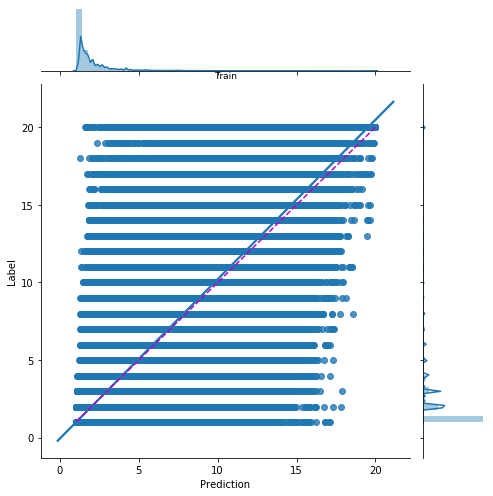

In [331]:
model_performance_sc_plot(rf_train_pred, Y_train, 'Train')

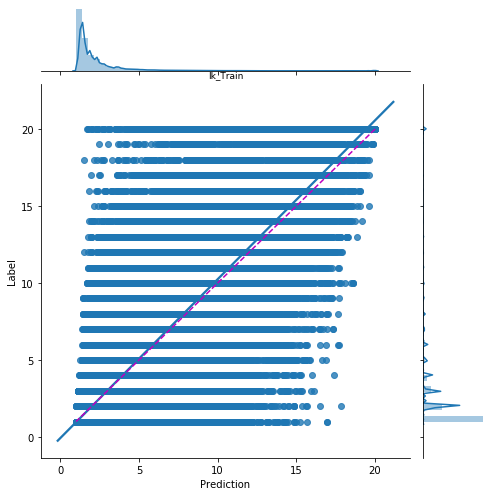

In [332]:
model_performance_sc_plot(rf_lk_train_pred, Y_lk_train, 'lk_Train')

In [333]:
rf_test_pred

array([1.23956564, 1.        , 1.54735192, ..., 1.09792724, 1.        ,
       1.10485122])

In [334]:
rf_lk_test_pred

array([1.24394959, 1.        , 1.65531971, ..., 1.22288555, 1.        ,
       1.18350296])

In [335]:
df_prediction=pd.DataFrame(rf_test_pred)
df_lk_prediction=pd.DataFrame(rf_lk_test_pred)

In [336]:
df_reset=df_prediction.reset_index()
df_reset.columns=['ID','item_cnt_month']
df_reset

,ID,item_cnt_month
0,0,1.239566
1,1,1.000000
2,2,1.547352
3,3,1.000000
4,4,1.000000
...,...,...
214195,214195,1.517075
214196,214196,1.000000
214197,214197,1.097927
214198,214198,1.000000


In [337]:
df_lk_reset=df_lk_prediction.reset_index()
df_lk_reset.columns=['ID','item_cnt_month']
df_lk_reset

,ID,item_cnt_month
0,0,1.243950
1,1,1.000000
2,2,1.655320
3,3,1.000000
4,4,1.000000
...,...,...
214195,214195,1.553478
214196,214196,1.000000
214197,214197,1.222886
214198,214198,1.000000


In [338]:
df_reset.to_csv('rf_train_submission.csv',index=False)
#1.37

In [339]:
df_lk_reset.to_csv('rf_lk_train_submission.csv',index=False)
#1.41
#并没有明显提升

Linear Regression

In [297]:
train_set.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'item_sum_cnt', 'revenue',
       'item_name', 'item_category_id', 'item_category_name', 'split', 'type',
       'type_code', 'subtype', 'subtype_code', 'shop_name', 'shop_city',
       'shop_type', 'shop_city_labeled', 'shop_type_labeled', 'year_month',
       'Year', 'Month', 'item_cnt_shop_item_lagged1',
       'item_cnt_shop_item_lagged2', 'item_cnt_shop_item_lagged3',
       'shop_item_avg_cnt', 'item_cnt_cat_lagged1', 'item_cnt_cat_lagged2',
       'item_cnt_cat_lagged3', 'shop_item_cat_avg_cnt',
       'item_cnt_date_shop_cat_lagged1', 'item_cnt_date_shop_cat_lagged2',
       'item_cnt_date_shop_cat_lagged3', 'shop_date_cat_avg_cnt',
       'item_cnt_date_shop_item_lagged1', 'item_cnt_date_shop_item_lagged2',
       'item_cnt_date_shop_item_lagged3', 'shop_date_item_avg_cnt',
       'item_avg_item_price', 'date_item_avg_item_price',
       'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_av

In [298]:
ln_features=['shop_id', 'item_id',
       'type_code', 'subtype_code','shop_city_labeled', 'shop_type_labeled', 'Year', 'Month', 'item_cnt_shop_item_lagged1',
       'item_cnt_shop_item_lagged2', 'item_cnt_shop_item_lagged3',
       'shop_item_avg_cnt', 'item_cnt_cat_lagged1', 'item_cnt_cat_lagged2',
       'item_cnt_cat_lagged3', 'shop_item_cat_avg_cnt',
       'date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_avg_item_price_lag_3', 'delta_price_lag_1',
       'delta_price_lag_2', 'delta_price_lag_3', 'delta_revenue_lag_1', 'item_shop_first_sale', 'item_first_sale']

In [299]:
ln_train=train_set[ln_features]
ln_val=validation_set[ln_features]
ln_test=test_set[ln_features]

In [300]:
Y_ln_train=train_set['item_sum_cnt']
Y_ln_validation=validation_set['item_sum_cnt']

In [301]:
# Normalizing features
ln_scaler = MinMaxScaler()
ln_scaler.fit(ln_train)
ln_train = ln_scaler.transform(ln_train)
ln_val = ln_scaler.transform(ln_val)
ln_test = ln_scaler.transform(ln_test)

In [302]:
ln_model = LinearRegression(n_jobs=-1)
ln_model.fit(ln_train, Y_ln_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [303]:
ln_train_pred = ln_model.predict(ln_train)
ln_val_pred = ln_model.predict(ln_val)
ln_test_pred = ln_model.predict(ln_test)

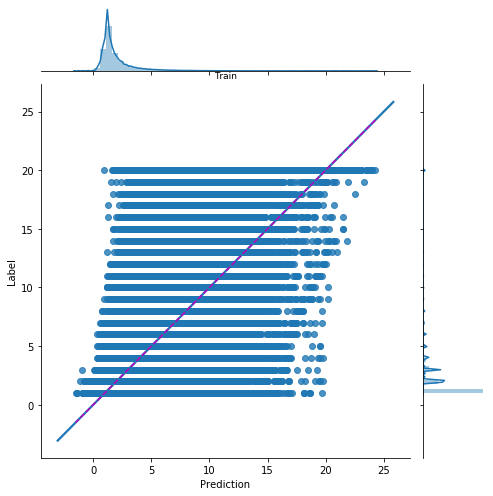

In [304]:
model_performance_sc_plot(ln_train_pred, Y_ln_train, 'Train')
# 1. 过拟，导致预测效果不佳
# 2. 减少模型中的feature

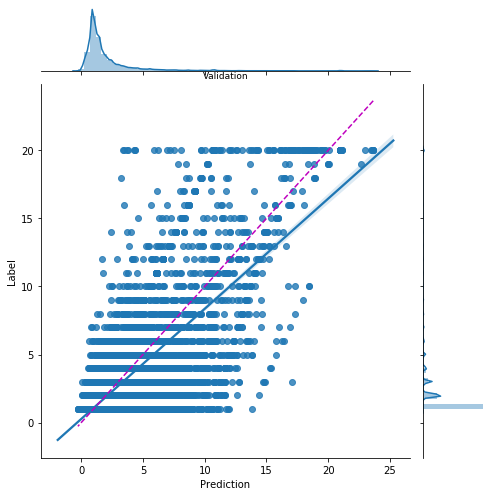

In [305]:
model_performance_sc_plot(ln_val_pred, Y_ln_validation, 'Validation')

In [306]:
df_ln_prediction=pd.DataFrame(ln_test_pred)

In [309]:
df_ln_reset=df_ln_prediction.reset_index()
df_ln_reset.columns=['ID','item_cnt_month']
df_ln_reset

,ID,item_cnt_month
0,0,1.010069
1,1,0.470573
2,2,1.752700
3,3,1.011829
4,4,0.481096
...,...,...
214195,214195,1.454197
214196,214196,0.411327
214197,214197,0.275895
214198,214198,0.300230


In [310]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(Y_ln_train, ln_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_ln_validation, ln_val_pred)))

Train rmse: 1.797470745489307
Validation rmse: 1.6839737936488959


In [312]:
df_ln_reset.to_csv('ln_train_submission.csv',index=False)
#1.36
#较random forest效果更好

反思与改进

1. 受限于电脑计算能力，较复杂的模型无法运行，还可以使用更流行的XGBoost模型来训练
2. 由于使用的feature较多，很容易造成过拟的问题，特征之间的多样性也是决定模型准确度的重要因素
3. 调参可使用GridSearch工具来作图自动调参，但是在数据量较大的情况下，受限于电脑计算能力本次没有尝试